In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfeffort = pd.DataFrame.from_csv('effort.csv')
dfweather = pd.DataFrame.from_csv('weather.csv')
dfdrought = pd.DataFrame.from_csv('drought.csv')
dfheavyPrecip = pd.DataFrame.from_csv('heavy-precip.csv')
dfprecip = pd.DataFrame.from_csv('precipitation.csv')
dftemperature = pd.DataFrame.from_csv('temperature.csv')
dfbald_eagle = pd.DataFrame.from_csv('bald_eagle_counts.csv')
dfchickadee = pd.DataFrame.from_csv('chickadee_counts.csv')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that som

# Examine bird populations

Let's have a look at the normalized bird densities (the number of observations over the number of man hours in that year's cbc) seen over the years with the cbc. 


### Bald Eagle: black
### Chickadee: red

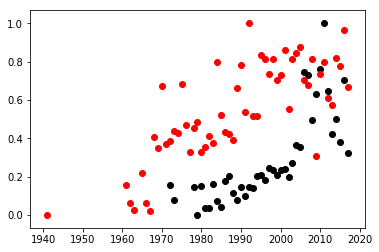

In [30]:
plt.scatter(dfbald_eagle.year, dfbald_eagle.density/max(dfbald_eagle[dfbald_eagle.year > 1980].density), color='k')
plt.scatter(dfchickadee.year, dfchickadee.density/max(dfchickadee.density), color='r')

# Begin Making model


We will try to predict the density of bird observations based on the various weather criteria, plotted together below.

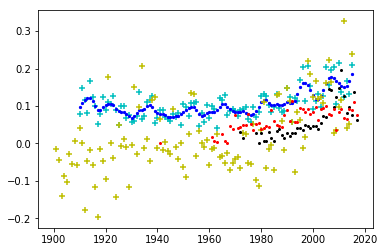

In [31]:
plt.scatter(dfheavyPrecip.year, dfheavyPrecip.index_value, color='c', marker='+')
plt.scatter(dfheavyPrecip.year, dfheavyPrecip.nine_yr_avg, color='b', s=5)
plt.scatter(dftemperature.year, dftemperature.earth_surface/10, color='y', marker='+')
plt.scatter(dfbald_eagle.year, dfbald_eagle.density, color='k', s=4)
plt.scatter(dfchickadee.year, dfchickadee.density/100, color='r', s=4)

# construct Y_chickadee

Use dictionaries with years associated to be careful.

### Start with chickadee only

... because the data is a little more complete.  Lets drop countYear 42 (1941) and just use 1961 and on.

In [114]:
dfchickadee = dfchickadee[dfchickadee.year > 1960]
dfchickadee = dfchickadee[dfchickadee.year < 2016]
Y_chickadee = np.array(dfchickadee.density.tolist())
Y_chickadee_dict = dict()
for i in range(len(dfchickadee)):
    Y_chickadee_dict[dfchickadee.iloc[i].year] = dfchickadee.iloc[i].density


In [115]:
print(len(Y_chickadee_dict), Y_chickadee_dict)

54 {1961: 1.7931, 1962: 0.697, 1963: 0.2857, 1965: 2.5, 1966: 0.7143, 1967: 0.2143, 1968: 4.5833, 1969: 3.9286, 1970: 7.6, 1971: 4.1667, 1972: 4.3939, 1973: 4.9545, 1974: 4.8361, 1975: 7.7294, 1976: 5.3162, 1977: 3.7091, 1978: 5.1408, 1979: 5.5106, 1980: 3.7282, 1981: 4.0282, 1982: 4.6519, 1983: 4.2698, 1984: 9.0147, 1985: 5.9318, 1986: 4.8973, 1987: 4.7685, 1988: 4.4552, 1989: 7.5078, 1990: 8.8803, 1991: 6.0987, 1992: 11.3314, 1993: 5.8231, 1994: 5.8456, 1995: 9.4302, 1996: 9.2156, 1997: 8.3404, 1998: 9.2165, 1999: 7.9538, 2000: 8.2908, 2001: 9.731, 2002: 6.232, 2003: 9.2267, 2004: 9.5665, 2005: 9.9516, 2006: 7.9725, 2007: 7.6872, 2008: 9.2347, 2009: 3.505, 2010: 8.3573, 2011: 9.0652, 2012: 6.9145, 2013: 6.5077, 2014: 9.2757, 2015: 8.8134}


# Construct Features

This magic function takes the year as an argument and returns the features from the very, very already-processed dataframes ``dftemperature, dfdrought, dfprecip, dfheavyPrecip``.

The feature list:

``[earth_surface_temp, drought_index, drought_nine_yr_avg, heavy_precip_index, heavy_precip_nine_yr_avg, precip_anomoly]``

In [120]:
def build_features(year_):
    X = []
    
    def lmap(func, alist):
        return list(map(func, alist))
        
    temp_row = dftemperature[dftemperature.year == year_]
    X = X + lmap(float, [temp_row.earth_surface])#,temp_row.lower_troposphere_uah, temp_row.lower_troposphere_rss]
    drought_row = dfdrought[dfdrought.year == year_]
    X = X + lmap(float, [drought_row.annual_avg, drought_row.nine_yr_avg])
    hprecip_row = dfheavyPrecip[dfheavyPrecip.year == year_]
    X = X + lmap(float, [hprecip_row.index_value, hprecip_row.nine_yr_avg])
    precip_row = dfprecip[dfprecip.year == year_]
    X = X + lmap(float, [precip_row.anomoly_inches])
    return np.array(X)
    

In [121]:
# test run
for i in range(1961,2016):
    print(build_features(i))

[-0.15        0.89083333 -0.04791341  0.1         0.08448828  1.31      ]
[-0.12        0.02083333 -0.5397526   0.093       0.08441016 -1.34      ]
[ 0.24       -2.92916667 -0.90830078  0.04        0.08855078 -4.24      ]
[-0.35       -1.0625     -0.91852214  0.122       0.09805859  0.32      ]
[-0.33        0.70833333 -0.62742513  0.117       0.10585156 -0.14      ]
[-0.53       -1.76416667 -0.16245443  0.129       0.10496094 -2.48      ]
[-0.26        0.435       0.45788086  0.075       0.09758594 -0.34      ]
[-0.7         1.79583333  1.06626953  0.087       0.09067187  0.45      ]
[-0.52        2.50166667  1.38129883  0.092       0.08689062  0.69      ]
[-0.41        0.7425      1.46689453  0.087       0.08487109 -0.24      ]
[-0.36        0.60333333  1.7450651   0.072       0.08425391  0.39      ]
[-0.65        1.97916667  2.39477539  0.088       0.08523828  1.76      ]
[0.27       4.8475     3.00868164 0.091      0.08549219 5.02      ]
[0.24       3.47416667 2.9914974  0.096     

# construct features dict

I am having issues with lengths, so I'll make a dictionary to be safe mapping years to feature vectors.

In [116]:
X_dict = dict()

for i in range(1961,2016):
    X_dict[i] = build_features(i)
    
print(len(X_dict), X_dict)

55 {1961: [-0.15, 0.890833333, -0.047913410999999996, 0.1, 0.084488281, 1.31], 1962: [-0.12, 0.020833333, -0.539752604, 0.09300000000000001, 0.084410156, -1.34], 1963: [0.24, -2.929166667, -0.9083007809999999, 0.04, 0.088550781, -4.24], 1964: [-0.35, -1.0625, -0.918522135, 0.122, 0.098058594, 0.32], 1965: [-0.33, 0.708333333, -0.62742513, 0.11699999999999999, 0.10585156300000001, -0.14], 1966: [-0.53, -1.7641666669999998, -0.16245442699999998, 0.129, 0.104960938, -2.48], 1967: [-0.26, 0.435, 0.457880859, 0.075, 0.09758593800000001, -0.34], 1968: [-0.7, 1.795833333, 1.0662695309999999, 0.087, 0.090671875, 0.45], 1969: [-0.52, 2.501666667, 1.381298828, 0.092, 0.086890625, 0.69], 1970: [-0.41, 0.7425, 1.466894531, 0.087, 0.08487109400000001, -0.24], 1971: [-0.36, 0.6033333329999999, 1.745065104, 0.07200000000000001, 0.08425390599999999, 0.39], 1972: [-0.65, 1.9791666669999999, 2.394775391, 0.08800000000000001, 0.085238281, 1.76], 1973: [0.27, 4.8475, 3.0086816410000004, 0.091, 0.085492188

### Oh, 1964 is missing from the chickadee data.  Let's remove it from the X_dict

In [122]:
X_dict = dict()

for i in range(1961,1964):
    X_dict[i] = build_features(i)

for i in range(1965,2016):
    X_dict[i] = build_features(i)
    
print(len(X_dict), X_dict)

54 {1961: array([-0.15      ,  0.89083333, -0.04791341,  0.1       ,  0.08448828,
        1.31      ]), 1962: array([-0.12      ,  0.02083333, -0.5397526 ,  0.093     ,  0.08441016,
       -1.34      ]), 1963: array([ 0.24      , -2.92916667, -0.90830078,  0.04      ,  0.08855078,
       -4.24      ]), 1965: array([-0.33      ,  0.70833333, -0.62742513,  0.117     ,  0.10585156,
       -0.14      ]), 1966: array([-0.53      , -1.76416667, -0.16245443,  0.129     ,  0.10496094,
       -2.48      ]), 1967: array([-0.26      ,  0.435     ,  0.45788086,  0.075     ,  0.09758594,
       -0.34      ]), 1968: array([-0.7       ,  1.79583333,  1.06626953,  0.087     ,  0.09067187,
        0.45      ]), 1969: array([-0.52      ,  2.50166667,  1.38129883,  0.092     ,  0.08689062,
        0.69      ]), 1970: array([-0.41      ,  0.7425    ,  1.46689453,  0.087     ,  0.08487109,
       -0.24      ]), 1971: array([-0.36      ,  0.60333333,  1.7450651 ,  0.072     ,  0.08425391,
        0.39      

In [148]:
X = []
for yr in X_dict.keys():
    X.append(X_dict[yr])
print(len(X), len(Y_chickadee))

54 54


# Linear Regression

Scatter plot shown below.  No cross validation attempted due to small sample - model is predicting on its own training set.  

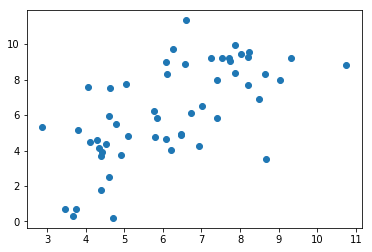

In [160]:
import sklearn
model = sklearn.linear_model.LinearRegression()
model.fit(X, Y_chickadee)
y_pred = model.predict(X)
plt.scatter(y_pred,Y_chickadee)

## Absolute error

Mean error in the bird density is 1.67.  Typical values for the chickadee bird density observed were on the order of 10.

In [166]:
residuals = y_pred - Y_chickadee
residuals = list(map(abs, residuals))
error = np.mean(residuals)
error

1.6707883607943044

## Coefficients analysis

The smallest coefficient is for drought nine_year_average.  However, the data were not normalized so the magnitude of the coefficients is not telling.  We can use ridge or lasso regression to figure out which coefficients are needed.

In [154]:
model.coef_

array([ 0.88727595,  0.12612395,  0.07036548, -9.53578597, 42.56498877,
        0.2286899 ])

# Lasso regression

This would be better put to use if I decided to use the satellite temperature anomoly data (since it is highly correlated with earth's surface temperature).

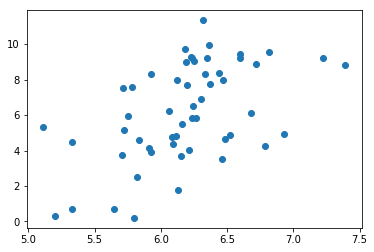

In [167]:
model = sklearn.linear_model.Lasso()
model.fit(X, Y_chickadee)
y_pred = model.predict(X)
plt.scatter(y_pred,Y_chickadee)

## Lasso kept only the precipitation anomoly and the earth_surface_temperature.

And it is not much worse in performace than the linear regression which kept all the features.  The absolute error for lasso is 2.14 v.s. 1.67 for linear regression.  

Cross validation and tuning paramaters in a ridge regression model would likely give the best performance.

In [157]:
model.coef_

array([ 0.25323592,  0.        , -0.        ,  0.        ,  0.        ,
        0.18607781])

In [168]:
residuals = y_pred - Y_chickadee
residuals = list(map(abs, residuals))
error = np.mean(residuals)
error

2.149264569180394